In [47]:
import re

import jsonlines
import pandas as pd
import numpy as np
import difflib

In [48]:
# # TODO: load metadata and return aggregate / summary statistics

logged_metadata = []

with jsonlines.open('../metadata/covers.jsonl', mode='r') as reader:
    for item in reader:
        logged_metadata.append(item)
        
df = pd.DataFrame(logged_metadata)

In [49]:
def get_issue_number_from_title(title):
    issue = re.search(r"([#?])(\d+)\b", title.replace(',', ''))
    if issue is None:
        return np.nan
    else:
        return np.int(issue.group().replace('#', ''))

df['issue_number'] = df['title'].apply(get_issue_number_from_title)

df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,43856,94,Saddle-stitched,17281
format_color,43856,43,Color,23154
format_dimensions,43856,116,Standard Modern Age US,9139
format_paper_stock,43856,140,,10818
format_publishing_format,43856,74,was ongoing series,16850
indexer_notes,43856,25840,,8471
indicia_frequency,43856,795,monthly,21175
issue_brand,43856,176,DC [bullet],7902
issue_indicia_publisher,43856,111,DC Comics,10687
issue_pages,43856,138,36,29990


In [50]:
flatten = lambda l: [item for sublist in l for item in sublist]

def match_brackets(characters: str):
    p = re.compile(r"\[(.*?)\]")
    matches = {}
    for m in p.finditer(characters):
        matches[m.group()] = {"start": m.start(), "end": m.end()}
    return matches


def replace_semicolons_in_brackets(characters: str):
    p = re.compile(r"\[(.*?)\]")
    matches = []
    for m in p.finditer(characters):
        matches.append((m.start(), m.end(), m.group()))
    for match in matches:
        substring = characters[match[0]: match[1]]
        if substring.count(";") == 1 and (("Kal-El" in substring) |  ("Zor-El" in substring)):
            characters = characters.replace(substring,  substring.replace(";", "/"))
        if substring.count(";") > 1:
            pass
    return characters


def look_behind(t, end_idx):
    span = t[: (end_idx - 1)]
    semicolon_matches = [(m.group(),m.start(),m.end()) for m in re.finditer(r"(?<=(;))", span)]
    if len(semicolon_matches) ==  0:
        start_idx = 0
    else:
        start_idx = semicolon_matches[-1][2]
    return span[start_idx: end_idx].strip()

def convert_character_dict_to_str(character_dict):
    return  str(character_dict["Teams"]).\
    replace("{", "").\
    replace("}", "").\
    replace("'", "").\
    replace(",", ";")

def diff_strings(string1,  string2):
    diff = ""
    for idx, val in enumerate(difflib.ndiff(string1, string2)):
        if val[0] == "+":
            diff += val[2]
    return diff

In [51]:
def convert_characters_to_list(t):
    
    t = replace_semicolons_in_brackets(t)

    stack = 0
    startIndex = None
    results = []

    matches = []
    for i, c in enumerate(t):
        if c == '[':
            if stack == 0:
                startIndex = i + 1 # string to extract starts one index later

            # push to stack
            stack += 1
        elif c == ']':
            # pop stack
            stack -= 1

            if stack == 0:
                matches.append((startIndex, i))
                results.append(t[startIndex:i])

    character_dict = {}
    character_dict["Teams"] = {}
    character_dict["Individuals"] = {}

    for span in matches:
        entity = t[span[0]: span[1]]
        if entity.count(";") == 0:
            person_name = look_behind(t, span[0])
            person_identity = entity
            character_dict["Individuals"][person_name] = person_identity

        elif entity.count(";") > 1:
            team_name = look_behind(t, span[0])
            team_members = list(filter(lambda x: x != "", entity.split("; ")))
            character_dict["Teams"][team_name] = team_members


    team_string = convert_character_dict_to_str(character_dict)

    remainder = diff_strings(team_string, t)

    remainder = list(filter(lambda x: x != "", remainder.split("; ")))

    character_dict["Individuals"] = remainder

    character_list = []
    for k in character_dict["Teams"]:
        character_list.append(character_dict["Teams"][k])

    character_list.append(character_dict["Individuals"])

    return flatten(character_list)

In [52]:
# create cover df
df_covers = pd.concat(df['covers'].apply(lambda x: pd.DataFrame(x).T).tolist(), axis=0)

# create cover characters df
df_cover_characters = df_covers[df_covers["cover_characters"].notnull()].reset_index(drop=True).copy()
df_cover_characters["cover_characters_list"] = df_cover_characters["cover_characters"].apply(convert_characters_to_list)

In [53]:
# # TODO: consolidate names of characters labeled on covers to reduce fragmentation in label space

print("Cover Characters:")

list(zip(pd.Series(flatten(df_cover_characters["cover_characters_list"].values)).value_counts()[:50].index,
    pd.Series(flatten(df_cover_characters["cover_characters_list"].values)).value_counts()[:50].values))

Cover Characters:


[('Batman [Bruce Wayne]', 2412),
 ('Superman', 2073),
 ('Spider-Man [Peter Parker]', 1997),
 ('Batman', 1673),
 ('Wolverine', 1257),
 ('Iron Man [Tony Stark]', 1254),
 ('Captain America [Steve Rogers]', 1148),
 ('Thor', 1070),
 ('Hulk [Bruce Banner]', 906),
 ('Wonder Woman', 894),
 ('Spider-Man', 844),
 ('Superman [Clark Kent/ Kal-El]', 834),
 ('Human Torch [Johnny Storm]', 789),
 ('Robin [Dick Grayson]', 743),
 ('Green Lantern [Hal Jordan]', 710),
 ('Cyclops', 659),
 ('Deadpool', 572),
 ('Flash [Barry Allen]', 557),
 ('Conan', 528),
 ('Storm', 511),
 ('Superboy', 507),
 ('Lois Lane', 505),
 ('Superman [Clark Kent]', 478),
 ('Flash [Wally West]', 473),
 ('Beast', 465),
 ('Green Arrow [Oliver Queen]', 441),
 ('Vision', 433),
 ('Hulk', 432),
 ('Aquaman', 431),
 ('Mr. Fantastic', 381),
 ('Iceman', 372),
 ('Colossus', 361),
 ('Joker', 344),
 ('Wonder Woman [Diana Prince]', 342),
 ('The Thing', 342),
 ('The Thing [Ben Grimm]', 332),
 ('Rogue', 312),
 ('Hercules', 290),
 ('Black Panther', 28

In [54]:
all_characters_instances = pd.Series(flatten(df_cover_characters["cover_characters_list"].values))

"There are {} unique character labels".format(len(all_characters_instances.unique()))

'There are 19597 unique character labels'

In [55]:
from comicvision.webscraper import strip_brackets

unique_characters = pd.Series(flatten(df_cover_characters["cover_characters_list"].values)).value_counts().index

# create character alias dict
aliases = {k: v for k, v in zip(unique_characters, [strip_brackets(x) for x in unique_characters])}

# apply aliases to character names
df_cover_characters["cover_characters_list_aliases"] = df_cover_characters["cover_characters_list"].apply(lambda x: [aliases[i] for i in x])

# create character count dict
character_counts = {k: v for k, v in 
                    zip(pd.Series(flatten(df_cover_characters["cover_characters_list_aliases"].values)).value_counts().index,
                        pd.Series(flatten(df_cover_characters["cover_characters_list_aliases"].values)).value_counts().values)}

In [56]:
# # TODO: write method to display cover image w/ cover metadata and add annotations to image
# # TODO: consider ideate/innotater for annotating directly in Jupyter notebooks

import os

from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance

def resize_im(im, dims):
    return im.resize(dims)

def save_im(im, save_to, im_type):
    im.save(save_to, im_type)
    
def get_im_rgb(im, size):
    rgb_im = im.convert('RGB')
    rgb = []
    for x in range(1, size[0]):
        for y in range(1, size[1]):
            rgb.append(rgb_im.getpixel((x, y)))
    dtypes = np.dtype('int, int, int')
    return np.array(rgb, dtype=dtypes)

In [57]:
covers = os.listdir('../covers/')

dims = []
for cover in covers:
    im = Image.open('../covers/' + cover)
    width, height = im.size
    dims.append((width, height))
    
"Calculated dims for {} covers".format(len(dims))

'Calculated dims for 53364 covers'

In [58]:
n = 60
pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
print('Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n')

top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
top_dims

print('Top Image Sizes:')
print(top_dims.values, '\n')
print('Height distribution:')
print('mean', round(pd.Series(map(lambda x: x[1], top_dims)).mean(), 0))
print('median', round(pd.Series(map(lambda x: x[1], top_dims)).median(), 0))
print('min', round(pd.Series(map(lambda x: x[1], top_dims)).min(), 0))
print('max', round(pd.Series(map(lambda x: x[1], top_dims)).max(), 0))
print('std', round(pd.Series(map(lambda x: x[1], top_dims)).std(), 0))

Top 60 image sizes account for 94.2% of covers 

Top Image Sizes:
[(400, 615) (400, 616) (400, 614) (400, 618) (400, 617) (400, 613)
 (400, 619) (400, 612) (400, 607) (400, 620) (400, 611) (400, 610)
 (400, 621) (400, 608) (400, 622) (400, 606) (400, 609) (400, 623)
 (400, 624) (400, 604) (400, 600) (400, 605) (400, 603) (400, 601)
 (400, 602) (400, 625) (400, 598) (400, 596) (400, 626) (400, 597)
 (400, 599) (400, 594) (400, 595) (400, 591) (400, 593) (400, 627)
 (400, 628) (400, 590) (400, 592) (400, 588) (400, 589) (400, 587)
 (400, 586) (400, 584) (400, 585) (400, 583) (400, 629) (400, 634)
 (400, 581) (400, 579) (400, 582) (400, 578) (400, 580) (400, 546)
 (400, 630) (400, 577) (400, 576) (400, 574) (400, 575) (400, 573)] 

Height distribution:
mean 601.0
median 602.0
min 546
max 634
std 19.0


### Show a random comic book cover

./covers/Iron Man: Iron Man #55 (400) Direct Edition ().jpg
Pencils: Kia Asamiya (painter, signed), Colors: Kia Asamiya (painter, signed)
['Iron Man']


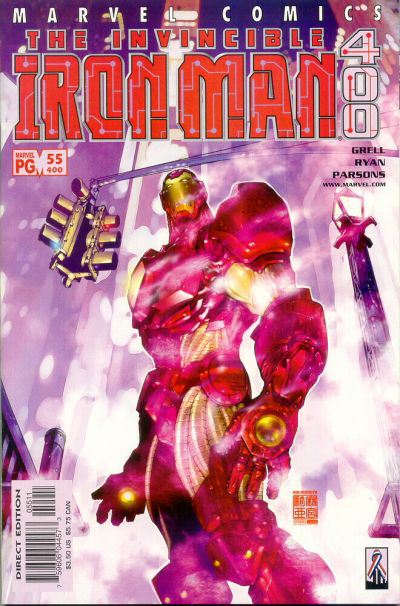

In [59]:
import random

cover_idx = random.randint(0, max(df_cover_characters.reset_index().index))

save_to = './covers/' + covers[cover_idx]
print(save_to)

try:
    pencils = df_cover_characters[df_cover_characters["save_to"] == save_to]["cover_pencils"].iloc[0]
except:
    pencils = ""
    
try:
    colors = df_cover_characters[df_cover_characters["save_to"] == save_to]["cover_colors"].iloc[0]
except:
    colors = ""

print("Pencils: {}, Colors: {}".format(pencils, colors))
try:
    print(df_cover_characters[df_cover_characters["save_to"] == save_to]["cover_characters_list_aliases"].iloc[0])
except:
    print("No characters...")
im = Image.open("." + save_to)
im

In [60]:
# learnings from examining random covers

# 1) exclude (inset) characters from labels??? or include them, as (inset)??? inset characters or not prominently featured on  the cover 
# but usually just shown as a head in a banner, or something like that.

# 2) there is some amount of label noise - variant covers do not always have characters labeled 
# (sometimes they inherit the character list from the original cover)

#3) there is also an amount of unlabeld covers, which can be easily labeled

In [61]:
from typing import List
from pandas import DataFrame

def get_random_sample_of_covers(df_covers: DataFrame, character: str, n: int) -> List[str]:
    """
    """
    df_covers = df_covers[df_covers["cover_characters_list_aliases"].apply(lambda x: character in x)].reset_index(drop=True)
    s = list(range(0,  max(df_covers.index)))
    random.shuffle(s)

    covers = {}
    for i in s[:n]:
        covers["cover_{}".format(i)] = {}

        image_path = df_covers["save_to"].iloc[i]
        characters = df_covers[df_covers["save_to"] == image_path]["cover_characters_list_aliases"].iloc[0]
        
        covers["cover_{}".format(i)]["image_path"] = image_path
        covers["cover_{}".format(i)]["characters"] = characters
        
        # check if image is duplicate (series, title, and issue # is already present)
    
    return covers

['Green Lantern']


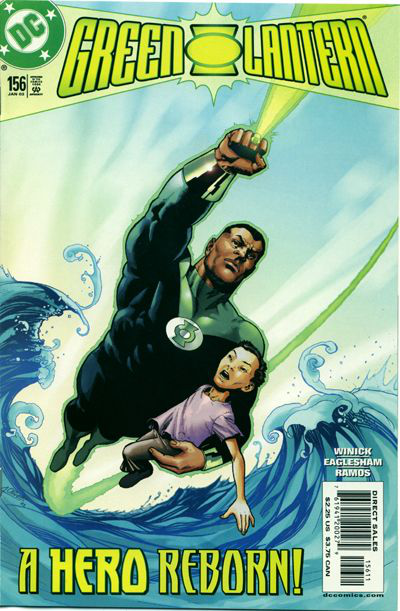

In [62]:
sample_character = "Green Lantern"
sample = get_random_sample_of_covers(df_cover_characters,  sample_character, n=1)
print(sample[list(sample.keys())[0]]["characters"])
sample_path = sample[list(sample.keys())[0]]["image_path"]
im = Image.open("." + sample_path)
im

In [63]:
# def get_value_counts(df, column):
#     return pd.Series("; ".join(df[column].\
#                                dropna()).\
#                      replace(" (signed)", "").\
#                      replace(" (painted)", "").\
#                      split('; ')).value_counts()

# print("Cover Artists:")

# list(zip(get_value_counts(df_covers, 'cover_pencils')[:100].index, 
#          get_value_counts(df_covers, 'cover_pencils')[:100].values))

In [64]:
[(k, character_counts[k]) for k in character_counts.keys()][:30]

[('Batman', 4512),
 ('Superman', 3564),
 ('Spider-Man', 3006),
 ('Green Lantern', 2408),
 ('Iron Man', 1605),
 ('Thor', 1600),
 ('Captain America', 1516),
 ('Wonder Woman', 1503),
 ('Flash', 1466),
 ('Wolverine', 1422),
 ('Robin', 1416),
 ('Hulk', 1399),
 ('Human Torch', 1178),
 ('Superboy', 944),
 ('Cyclops', 800),
 ('Deadpool', 734),
 ('The Thing', 693),
 ('Green Arrow', 672),
 ('Aquaman', 638),
 ('Mr. Fantastic', 623),
 ('Supergirl', 607),
 ('Storm', 604),
 ('Beast', 596),
 ('Conan', 528),
 ('Lois Lane', 506),
 ('Nightwing', 503),
 ('Hawkeye', 487),
 ('Captain Marvel', 487),
 ('Iceman', 482),
 ('Doctor Strange', 479)]

In [65]:
# TODO: dedupe covers (British, Canadian variants, etc...)
# TODO: exclude cover spreads

# import numpy as np

# for i in range(0, len(covers)):
#     im = Image.open('../covers/' + covers[i])
#     width, height = im.size
#     if (height < 565.0) | (height > 637.0):
#         pass
#     else:
#         im_resize = resize_im(im, (400, 600))
#         im_resize.save('../covers_filtered/' + covers[i])

# path\
#   train\
#     clas1\
#     clas2\
#     ...
#   valid\
#     clas1\
#     clas2\
#     ...
#   test\

from typing import List

def create_training_dirs(save_dir: str, characters_dict: dict):
    """
    create two dirs: images/ & annotations/
    """
    cover_samples = {}
    for character in characters_dict:
        cover_samples[character] = get_random_sample_of_covers(df_cover_characters, character, n=characters_dict[character])
        for cover in cover_samples[character]:
            indices = [1 if x in cover_samples[character][cover]["characters"] else 0 for x in list(characters_dict.keys())]
            cover_samples[character][cover]["label"] = [x[0] for x in  filter(lambda x: x[1] == 1, zip(characters_dict.keys(), indices))]
        
    all_dicts = []

    for hero_key in cover_samples.keys():
        for cover_key in cover_samples[hero_key].keys():
            title = cover_samples[hero_key][cover_key]["image_path"].split("/")[-1].strip()

            all_dicts.append({"id": title, 
                              "label": cover_samples[hero_key][cover_key]["label"],
                              "image_path": cover_samples[hero_key][cover_key]["image_path"]})

    dicts = list({v['id']:v for v in all_dicts}.values())
    random.shuffle(dicts)
    print("We started with {} covers. After de-duping for character overlap we have {}.".format(len(all_dicts), len(dicts)))
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir + "/images")
            
    for cover in dicts:

        save_image_to = save_dir + "/images/" + cover["id"]

        im = Image.open('.' + cover["image_path"])
        im = resize_im(im, dims=(400, 600))

        # save image
        save_im(im, save_image_to, im_type="jpeg")
        
        # write annotations/labels (if not imagenet style)
        name = cover["id"]
        label = str(cover["label"]).replace("[", "").replace("]", "").replace("'", "").replace(", ", "|").strip()
        record = [name, label]
        if len(record) == 2:
            # save label
            with open(save_dir + "/labels.txt", 'a') as f:
                f.write('\t'.join(record))
                f.write('\n')
        else:
            print("wtf happend?")
            print(record)


In [ ]:
# characters and number of covers to include in training set
characters_dict = {"Superman": 3100,
                   "Batman": 3800,
                   "Green Lantern": 2200,
                   "Wonder Woman": 1400, 
                   "Flash": 1350, 
                   "Aquaman": 550,
                   "Cyborg": 300}

create_training_dirs(save_dir="justice_league", characters_dict=characters_dict)

In [38]:
# # TODO: load metadata and return aggregate / summary statistics

logged_metadata = []

with jsonlines.open('../metadata/log.jsonl', mode='r') as reader:
    for item in reader:
        logged_metadata.append(item)
        
log = pd.DataFrame(logged_metadata)

log[["issue_count", "publisher_id", "publisher_page"]] = log[["issue_count", "publisher_id", "publisher_page"]].astype(int)

sorted_log = log.\
drop_duplicates().\
sort_values(by=["publisher_id",  "publisher_page", "series"])\
[["publisher_id",  "publisher_page", "series", "issue_count"]]

In [40]:
sorted_log[sorted_log["publisher_id"] == 78][20:]

,publisher_id,publisher_page,series,issue_count
23,78,31,None,12
124,78,31,None,4
24,78,32,Guardians of the Galaxy,2
34,78,33,None,10
35,78,34,None,2
44,78,35,None,4
30,78,36,None,6
45,78,37,None,5
25,78,38,None,3
61,78,42,None,3
